# Mount google drive and Load Modules

Note: current ***tensorflow*** version used in this work is ***2.9.2***

In [ ]:
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/gdrive/')
#Lib imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as spliter
from sklearn import preprocessing
import joblib
!pip3 install pickle5
import pickle5 as pickle
from sklearn.utils import shuffle
from collections import defaultdict
tf.__version__

Mounted at /content/gdrive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 32.2 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp38-cp38-linux_x86_64.whl size=236296 sha256=768e3b00bd768fb321219d07db9bc900ecbe8d5cfbe1db219ed2db106d3470a2
  Stored in directory: /root/.cache/pip/wheels/25/d4/61/dbd8edd1a0d656be7b4267c85db3b61951eb60016a0154a122
Successfully built pickle5


'2.9.2'

# Read the dataset

***Dataset Outline***  (also available in readme file in module folder)<br>
1. ***data_dump_density_preprocessed_V2.pk*** -----> All data containing 4050 data samples<br>

2. ***data_dump_density_preprocessed_train.pk*** ----->  3550 training samples using random splitting methods to drop 500 random samples from the whole 4050 dataset    <br>
    ***data_dump_density_preprocessed_test.pk*** -----> 500 random dropped samples used for testing      <br>

3. ***data_dump_density_preprocessed_train_excludeX.pk*** -----> Exclude certian samples involving [X] as input parameters using deterministic splitting methods with sample size = 4050 - N(X)    <br>
    ***data_dump_density_preprocessed_test_excludeX.pk*** -----> Corresponding excluded testing dataset include N(X) samples

This example uses training samples with random splitting methods includes 3550 training samples and 500 cooresponding testing samples. The data dumping and ML model training process is similar for using deterministic splitting method. 


In [ ]:
file_path= "/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/Ions_in_confinement/all_data_4050/"
with open(file_path+ 'data_dump_density_preprocessed_train.pk', 'rb') as handle:
    processed_all_data_preprocessed_train = pickle.load(handle)
with open(file_path+ 'data_dump_density_preprocessed_test.pk', 'rb') as handle:
    processed_all_data_preprocessed_test = pickle.load(handle)

# Preprocess the dataset and create numpy arrays from dictionary objects

Dictionary objects data structure: <br> 
Key: ***strings include input parameters*** (e.g.) Z_4.2_p_1_n_-1_d_0.2_a_0.2_c_0.1_i_0.0 <br> 
Data: "pos", "neg" -----> ***Column 0: z_data_values, Column 1: density_profiles, Column 2: density_errors***

Note that there is a mistake when computing density_errors, the correct density_errors should be density_errors/2.1

In [ ]:
NUM_OF_BINS = 502
def preprocess_inputdata(all_data):
  input_data = []
  output = []
  errors = []
  z_data = []

  #exlclude_paras = {"c": ["0.25", "0.75", "1.25", "1.75"]}
  exlclude_paras = {}
  for key, data in all_data.items():
    #print(key, data)
    density_profiles = []
    density_errors = []
    z_data_values = []
    input_names = key.split("_")[0::2]
    input_paras = key.split("_")[1::2]

    ignore_this = False
    for key_p, params in exlclude_paras.items():
        if input_paras[input_names.index(key_p)] in params:
            ignore_this= True
            break
    if ignore_this:
        continue

    input_data.append(input_paras)
    density_profiles.append(data['pos'][:,1])
    density_profiles.append(data['neg'][:,1])
    output.append(density_profiles)
    density_errors.append(data['pos'][:,2])
    density_errors.append(data['neg'][:,2])
    errors.append(density_errors)
    z_data_values.append(data['pos'][:,0])
    z_data_values.append(data['neg'][:,0])
    z_data.append(z_data_values)

    #break

  input_data = np.array(input_data)
  output = np.array(output).reshape(-1,NUM_OF_BINS*2)
  errors = np.array(errors).reshape(-1,NUM_OF_BINS*2)
  z_data = np.array(z_data).reshape(-1,NUM_OF_BINS*2)
  print("Input data shape: {}".format(input_data.shape))
  print("Output data shape: {}".format(output.shape))
  print("error bar data shape: {}".format(errors.shape))
  print("Bin center data shape: {}".format(z_data.shape))

  return input_data, output, errors, z_data


# Strategy to Reduce Training Size

In [ ]:
#reduce training set size by randomly excluding N data.
np.random.seed(0)   #fix random seed
index_ = np.random.choice(len(processed_all_data_preprocessed_train.keys()), 0,replace=False)  #change choice size to select reduced training samples
#label_ = list(processed_all_data_preprocessed_10ns.keys())[index_]
excluded_index_ = np.delete(np.arange(0,len(processed_all_data_preprocessed_train.keys())), index_)
train_ = {}
exclude_ = {}
for index in index_:
    exclude_[list(processed_all_data_preprocessed_train.keys())[index]] = processed_all_data_preprocessed_train[list(processed_all_data_preprocessed_train.keys())[index]]
for index in excluded_index_:
    train_[list(processed_all_data_preprocessed_train.keys())[index]] = processed_all_data_preprocessed_train[list(processed_all_data_preprocessed_train.keys())[index]]


In [ ]:
#Verify reduced training samples and the fixed independent testing samples
input_data, output, errors, z_data = preprocess_inputdata(train_)
input_data_test, output_test, errors_test, z_data_test = preprocess_inputdata(processed_all_data_preprocessed_test)

Input data shape: (3550, 7)
Output data shape: (3550, 1004)
error bar data shape: (3550, 1004)
Bin center data shape: (3550, 1004)
Input data shape: (500, 7)
Output data shape: (500, 1004)
error bar data shape: (500, 1004)
Bin center data shape: (500, 1004)


# Select data for model training

In [ ]:
#Using cross-validation with fraction of 0.8
train_test_split = 0.8
seed = 1

print("Input data shape: {}".format(input_data.shape))
print("Output data shape: {}".format(output.shape))

input_data_suff, output_suff,  errors_suff, z_data_shuff = shuffle(input_data, output, errors, z_data, random_state=seed)
#input_data_suff, output_suff,  errors_suff, z_data_shuff = shuffle(input_data, output, errors, z_data)
#input_data_suff_baseline, output_suff_baseline,  errors_suff_baseline, z_data_shuff_baseline = shuffle(input_data_baseline, output_baseline, errors_baseline, z_data_baseline, random_state=seed)

train_test_split_ = int(input_data_suff.shape[0]*train_test_split)

x_train = input_data_suff[0:train_test_split_]#.astype("float64")
x_test = input_data_suff[train_test_split_:]#.astype("float64")
#x_test_baseline = input_data_suff_baseline[train_test_split_:]#.astype("float64")


y_train = output_suff[0:train_test_split_]#.astype("float64")
y_test = output_suff[train_test_split_:]#.astype("float64")
#y_test_baseline = output_suff_baseline[train_test_split_:]#.astype("float64")

error_train = errors_suff[0:train_test_split_]#.astype("float64")
error_test = errors_suff[train_test_split_:]#.astype("float64")
#error_test_baseline = errors_suff_baseline[train_test_split_:]#.astype("float64")

z_data_train = z_data_shuff[0:train_test_split_]#.astype("float64")
z_data_test = z_data_shuff[train_test_split_:]#.astype("float64")
#z_data_test_baseline = z_data_shuff_baseline[train_test_split_:]#.astype("float64")


#x_train, x_test, y_train, y_test = spliter.train_test_split(input_data, output, test_size=(1-train_test_split), random_state=100)

print("Train input: ", x_train.shape)
print("Train Output", y_train.shape)
print("Test input: ", x_test.shape)
print("Test Output", y_test.shape)

Input data shape: (3550, 7)
Output data shape: (3550, 1004)
Train input:  (2840, 7)
Train Output (2840, 1004)
Test input:  (710, 7)
Test Output (710, 1004)


# Input feature scaling

***scaler_new.pkl*** -----> Scaler modules fitting with the maximum and the minimum of the original input parameter spaces. 


In [ ]:
scaler = joblib.load(file_path+'scaler_new.pkl')
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

# Model parameters

In [ ]:
# hyper parameters
learningRate = 0.0001
beta_1 = 0.9
beta_2 = 0.999
decay = 0.000000

batchSize = 32
dropout_rate=0.1
epochs= 20000

# Network Parameters
inputFeatures = 7
hiddenUnits1 = 256 # 1st layer number of neurons
hiddenUnits2 = 512 # 2nd layer number of neurons
#hiddenUnits3 = 512 # 3rd layer number of neurons
outputClasses = NUM_OF_BINS*2

# ANN Model

In [ ]:
#This is He initializer
#initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal', seed=None)
initializer = tf.keras.initializers.GlorotNormal(seed=None)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(hiddenUnits1, activation=tf.nn.relu, kernel_initializer=initializer, input_shape=(inputFeatures, )))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(hiddenUnits2, activation=tf.nn.sigmoid , kernel_initializer=initializer))
model.add(tf.keras.layers.Dropout(rate=dropout_rate))
model.add(tf.keras.layers.Dense(outputClasses, activation=tf.nn.relu, kernel_initializer=initializer))


model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate, beta_1=beta_1,beta_2=beta_2, decay=decay))

# Training

In [ ]:
history = model.fit(scaled_x_train, y_train, epochs=epochs, batch_size = batchSize, verbose = 1, validation_data = (scaled_x_train, y_train), shuffle=True)

流式输出内容被截断，只能显示最后 5000 行内容。
89/89 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 6.0606e-04
Epoch 17502/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 5.6728e-04
Epoch 17503/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 5.5627e-04
Epoch 17504/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 5.4767e-04
Epoch 17505/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 5.5431e-04
Epoch 17506/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 5.4161e-04
Epoch 17507/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 5.4923e-04
Epoch 17508/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 5.6758e-04
Epoch 17509/20000
89/89 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 5.8887e-04
Epoch 1751

# Model details and save the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1004)              515052    
                                                                 
Total params: 648,684
Trainable params: 648,684
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'val_loss'])


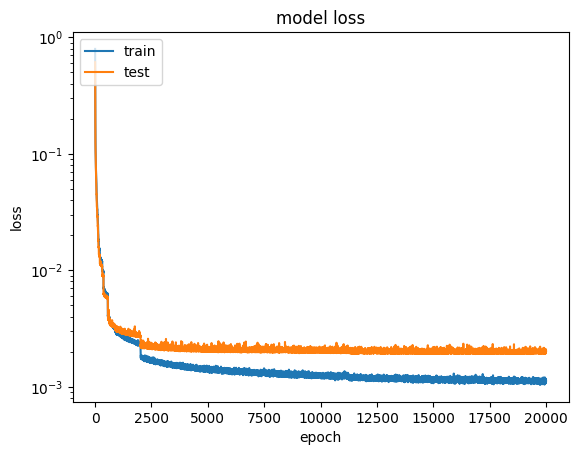

In [ ]:
model.summary()
file_path_model = "/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/Ions_in_confinement/saved_model/"
model.save(file_path_model+ 'my_model_base_excludeRandom_3550.h5')
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Load the models

In [ ]:
file_path_model = "/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/Ions_in_confinement/saved_model/"
#scaler = joblib.load(file_path+'scaler_new.pkl')
new_model = tf.keras.models.load_model(file_path_model+'my_model_base_excludeRandom_3550.h5', compile=False)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1004)              515052    
                                                                 
Total params: 648,684
Trainable params: 648,684
Non-trainable params: 0
_________________________________________________________________


# Predict and evalute RMSE value

In [ ]:
def evaluate_RMSE_k(prediction, truth , errorbar):
  RMSEk = []
  for i in range(prediction.shape[1]):
    cnt = 0;
    for j in range(prediction.shape[0]):
      cnt = cnt + (prediction[j,i] - truth[j,i])*(prediction[j,i] - truth[j,i]);
    RMSEk.append(cnt/prediction.shape[0]);

  return np.array(RMSEk)

predictions = new_model.predict(scaler.transform(x_test))
RMSE_k = evaluate_RMSE_k(predictions, y_test, error_test)
rmse_k_squared_root = np.sqrt(RMSE_k)

print(np.mean(rmse_k_squared_root))